# Part IV - Chapter 24. Advanced Analytics and Machine Learning Overview

## Spark's MLlib package

It consists of two packages that leverage different core data stuctures.

* `org.apache.spark.ml` includes an interface with DataFrames. It also sports an interface to build pipelines.
* `org.apache.spark.mllib` includes an interface for low level RDDs.

The book only focuses on the `ml` interface.

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder.master("local").appName("chapter24").getOrCreate()

In [2]:
# difference between dense and sparse vectors
from pyspark.ml.linalg import Vectors

dense_vec = Vectors.dense(1.0, 2.0, 3.0)
size = 3
idx = [1, 2]
values = [2., 3.]
sparse_vec = Vectors.sparse(size, idx, values)

print(dense_vec)
print(sparse_vec)

[1.0,2.0,3.0]
(3,[1,2],[2.0,3.0])


## MLlib in Action

This is an overview of how to structure a ML model using transformers, estimators, hyperparameter tunning and pipelines.

In [3]:
df = spark.read.json('../data/simple-ml')
df.orderBy("value2").limit(10).show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green|good|    12|14.386294994851129|
|green|good|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|green| bad|    16|14.386294994851129|
|  red| bad|     2|14.386294994851129|
+-----+----+------+------------------+



### Feature engineering with transformers

For an explanation of RFormula take a look at https://spark.apache.org/docs/latest/ml-features.html#rformula

In [4]:
from pyspark.ml.feature import RFormula

# lab ~ w1*color + w2*value1 +w3*value2 + w4*color*value1 + w5*color*value2 * w0
# it unravels the color in a one-hot encoding, yielding 10 features
supervised = RFormula(formula="lab ~ . + color:value1 + color:value2")
prepared_df = supervised.fit(df).transform(df)
prepared_df.limit(10).show()
prepared_df.select("features").take(5)

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
+-----+----+------+------------------+--------------------+-----+



[Row(features=SparseVector(10, {1: 1.0, 2: 1.0, 3: 14.3863, 5: 1.0, 8: 14.3863})),
 Row(features=SparseVector(10, {2: 8.0, 3: 14.3863, 6: 8.0, 9: 14.3863})),
 Row(features=SparseVector(10, {2: 12.0, 3: 14.3863, 6: 12.0, 9: 14.3863})),
 Row(features=SparseVector(10, {1: 1.0, 2: 15.0, 3: 38.9719, 5: 15.0, 8: 38.9719})),
 Row(features=SparseVector(10, {1: 1.0, 2: 12.0, 3: 14.3863, 5: 12.0, 8: 14.3863}))]

In [5]:
import pandas as pd
from pyspark.sql.functions import col

def print_pretty_dense(num_pos):
    np_mat = [prepared_df.select(col("features")).take(num_pos)[pos].features.toArray() for pos in range(num_pos)]
    return pd.DataFrame(np_mat)
    
print_pretty_dense(7)

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,1.0,14.386295,0.0,1.0,0.0,0.000000,14.386295,0.000000
1,0.0,0.0,8.0,14.386295,0.0,0.0,8.0,0.000000,0.000000,14.386295
2,0.0,0.0,12.0,14.386295,0.0,0.0,12.0,0.000000,0.000000,14.386295
3,0.0,1.0,15.0,38.971871,0.0,15.0,0.0,0.000000,38.971871,0.000000
4,0.0,1.0,12.0,14.386295,0.0,12.0,0.0,0.000000,14.386295,0.000000
5,0.0,1.0,16.0,14.386295,0.0,16.0,0.0,0.000000,14.386295,0.000000
6,1.0,0.0,35.0,14.386295,35.0,0.0,0.0,14.386295,0.000000,0.000000


In [6]:
# demo the train, test split
train_df, test_df = prepared_df.randomSplit([0.7, 0.3])
print("train dataset has {} rows".format(train_df.count()))
print("test dataset has {} rows".format(test_df.count()))

train dataset has 80 rows
test dataset has 30 rows


### Estimators

In [7]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features")
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [8]:
fitted_lr = lr.fit(train_df)
fitted_lr.transform(train_df).select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



### Pipelininig our workflow

In [9]:
from pyspark.ml import Pipeline

train_df, test_df = df.randomSplit([0.7, 0.3])

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100 )
rForm = RFormula()
stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

### Training and evaluation

We optimize hyperparameters (including feature extraction) by using a parameter grid search.

In [10]:
from pyspark.ml.tuning import ParamGridBuilder

params = ParamGridBuilder().addGrid(rForm.formula, ["lab ~ . + color:value1",
                                                   "lab ~ . + color:value1 + color:value2"])\
                            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
                            .addGrid(lr.regParam, [0.1, 2.0]).build()

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderROC")\
                                            .setRawPredictionCol("prediction")\
                                            .setLabelCol("label")

In [12]:
from pyspark.ml.tuning import TrainValidationSplit

tvs = TrainValidationSplit().setTrainRatio(0.75)\
                            .setEstimatorParamMaps(params)\
                            .setEstimator(pipeline)\
                            .setEvaluator(evaluator)
            
tvs_fitted = tvs.fit(train_df)
evaluator.evaluate(tvs_fitted.transform(test_df))

0.9210526315789473

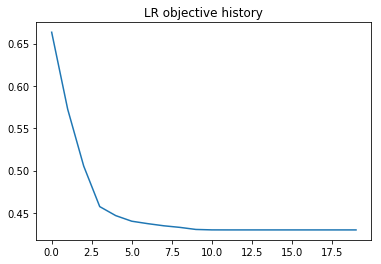

In [13]:
import matplotlib.pyplot as plt

plt.plot(tvs_fitted.bestModel.stages[1].summary.objectiveHistory)
plt.title('LR objective history')
plt.show()

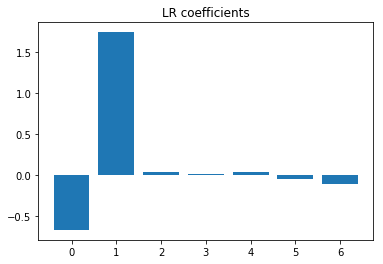

In [14]:
coeffs = tvs_fitted.bestModel.stages[1].coefficients.values
len(coeffs)
plt.bar(left=range(7), height=coeffs)
plt.title("LR coefficients")
plt.show()

### Extracting the hyperparameters from the best estimator
As explained in https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark the methods `extractParamMap` would not work

In [15]:
tvs_fitted.bestModel.extractParamMap()

{}

In [16]:
tvs_fitted.bestModel.params

[]

Instead access the java property under the hood

In [17]:
best_reg = tvs_fitted.bestModel.stages[1]._java_obj.getRegParam()
print("Best regularization param = {}".format(best_reg))

best_en = tvs_fitted.bestModel.stages[1]._java_obj.getElasticNetParam()
print("Best elastic net param = {}".format(best_en))

Best regularization param = 0.1
Best elastic net param = 0.0


### Writing the model to disk for later retrieval and deployment

In [18]:
tvs_fitted.bestModel.write().overwrite().save("../tmp/chapter-24-model")

In [19]:
# loading back from disk
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load("../tmp/chapter-24-model")
evaluator.evaluate(loaded_model.transform(test_df))

0.9210526315789473